<a href="https://colab.research.google.com/github/N3wBaz/ml-intro/blob/main/5_classification_linear_knn/hw_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification. Linear models and KNN

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(1.75 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [ ]:
from sklearn.exceptions import NotFittedError

In [ ]:
 def get_loss(self, x, weights, y):
        """Calculate the loss."""

        temp = []
        for j in range(x.shape[0]):
            q =  np.log(1 + np.exp(-weights[1:] @ x[j] * y[j]))
            temp.append(q)
        loss = np.sum(temp, axis=0) / x.shape[0] + weights.T @ weights / (2 * self.C)

        return loss

In [ ]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_container = []

         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value.""" 
        h = X @ weights
        return 1 / (1 + np.exp(-h))

    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        temp = []

        for j in range(x.shape[0]):
            q =  np.log(1 + np.exp(-weights[1:] @ x[j] * y[j]))
            temp.append(q)
        loss = np.sum(temp, axis=0) / x.shape[0] + weights.T @ weights / (2 * self.C)
        return loss

     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        for i in range(self.max_iter):

            temp = []          
            for j in range(X.shape[0]):
                q =  1 - 1 / (1 + np.exp(-self.weights_ @ X_ext[j] * y[j]))
                temp.append(X_ext[j] * y[j] * q )
            delta = np.sum(temp, axis=0) / X.shape[0] - self.weights_ / self.C
            self.weights_ -= -self.eta * delta
            self.loss_container.append(self.get_loss(X, self.weights_,y))
            if np.sqrt(np.sum(np.square(delta))) < self.tol:
                break

     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """

        predict = self.predict_proba(X)
        predict[predict >= 0.5] = 1
        predict[predict < 0.5] = -1

        return predict

In [3]:
from sklearn import datasets
from sklearn import metrics

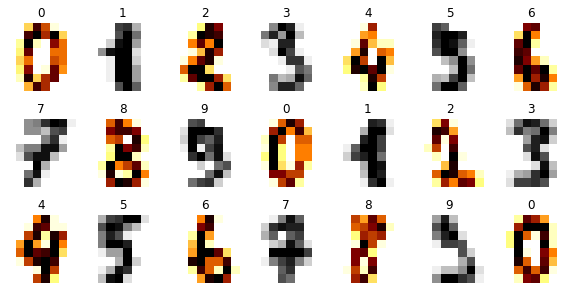

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [ ]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [4]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [ ]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [ ]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [ ]:
lr_clf.fit(X_train, y_train)
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [ ]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [ ]:
model = CustomLogisticRegression(max_iter=2000)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


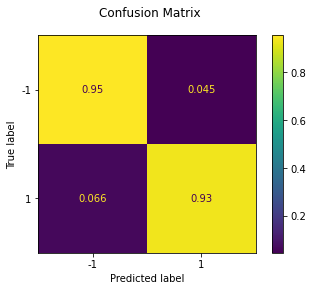

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
train_acc, test_acc

(0.9144050104384134, 0.9444444444444444)

In [ ]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Представлен график зависимости Loss логистической регрессии от количества итераций

In [ ]:
def plot_fit(model):
    loss = model.loss_container
    iter = [*range(0, len(loss) )]
    tick = np.linspace(0, len(loss), 1 + 40)
    plt.figure(figsize=(17, 10))
    plt.plot(iter, loss, label='Loss')
    plt.title('Loss for logistic regression')
    plt.xlabel('Number of  iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    # # plt.yscale('log')
    plt.xticks(tick, rotation='vertical')
    plt.legend(loc='center right')        
        
    plt.show()

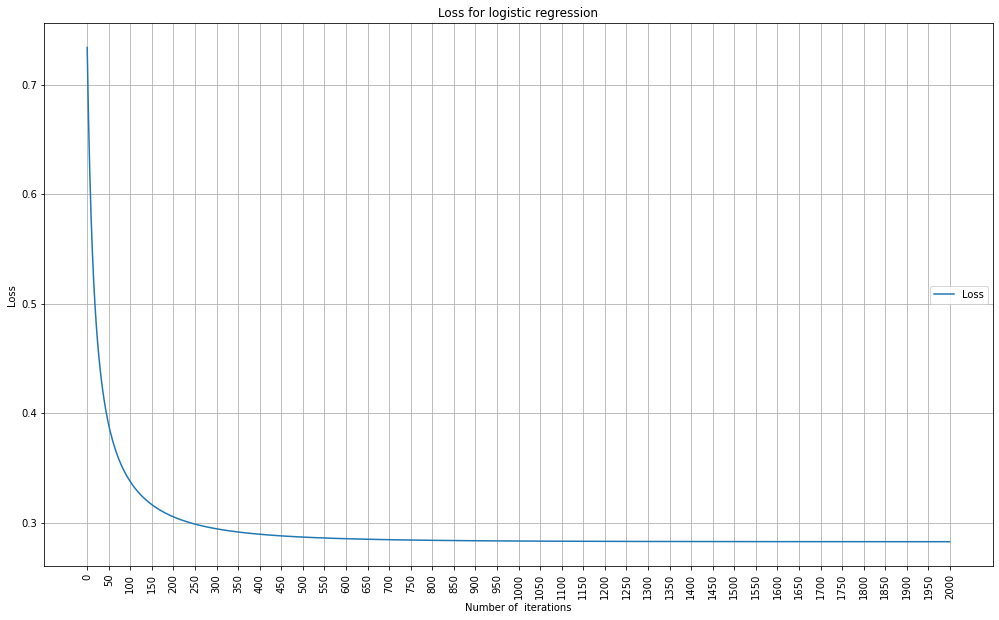

In [ ]:
plot_fit(model)

Как мы видим значение лосс функции уменьшается с увеличением числа итераций

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

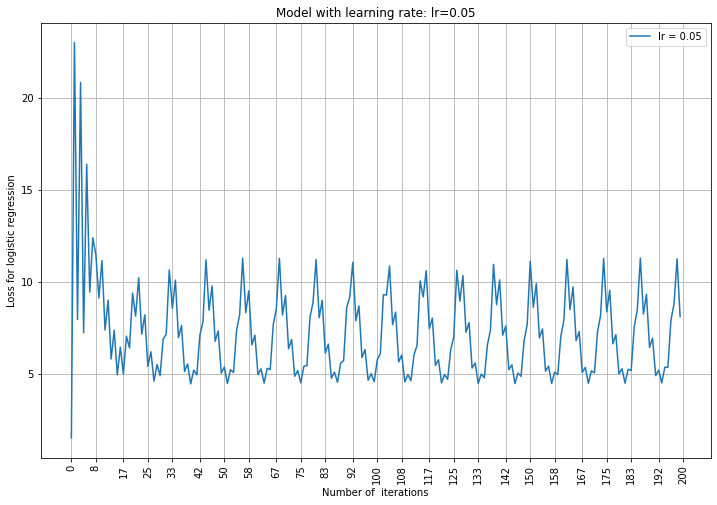

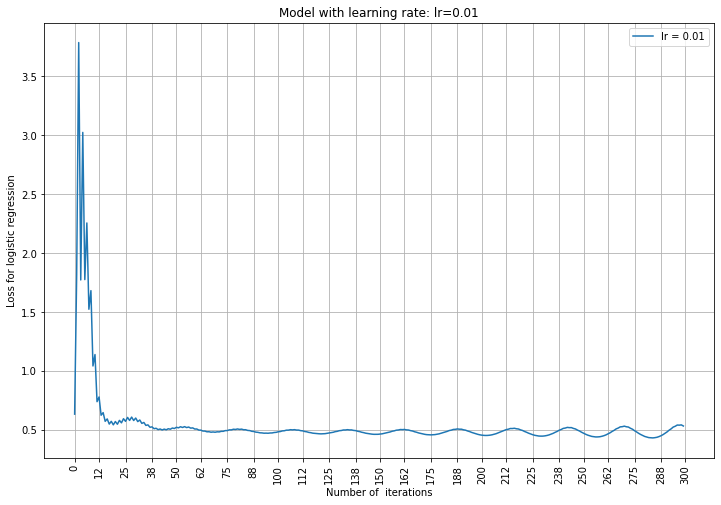

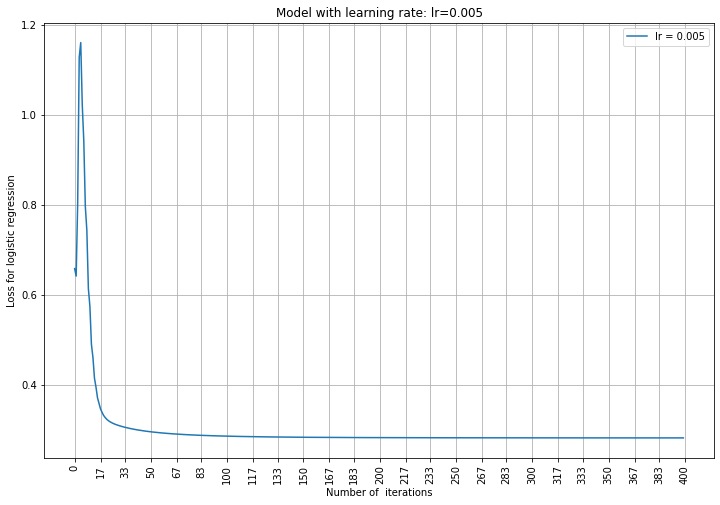

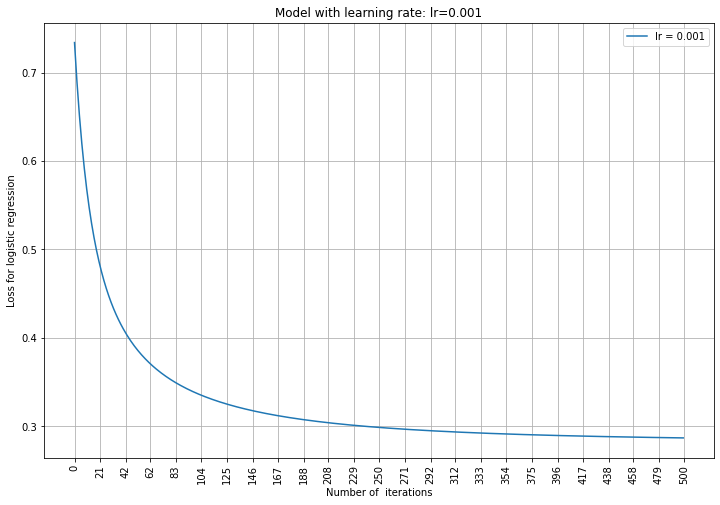

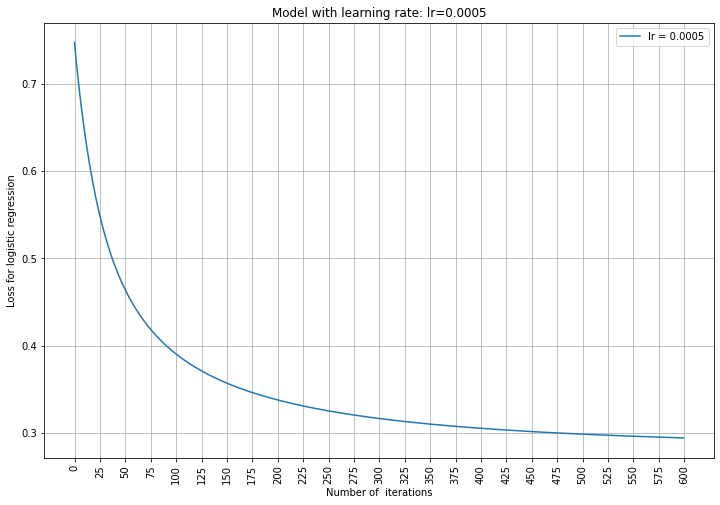

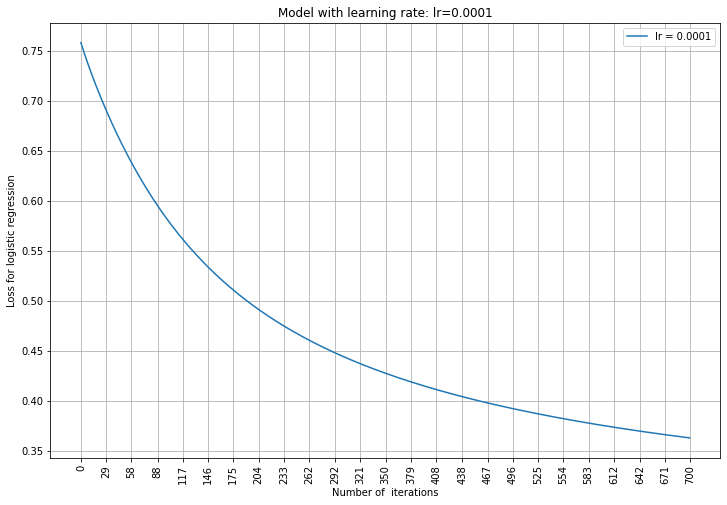

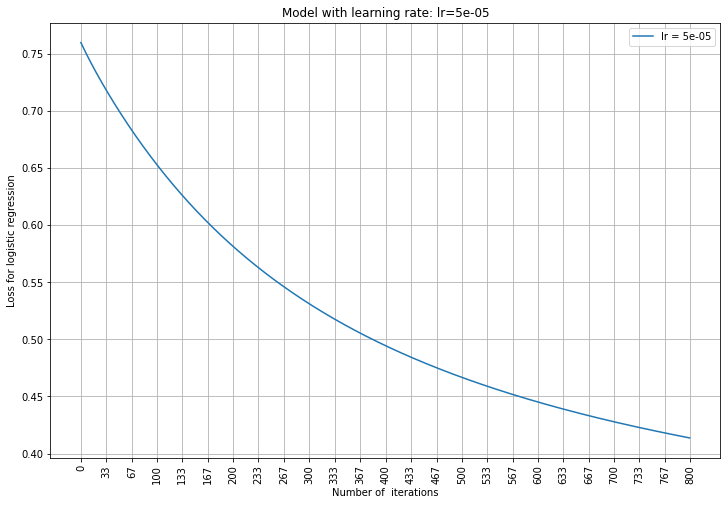

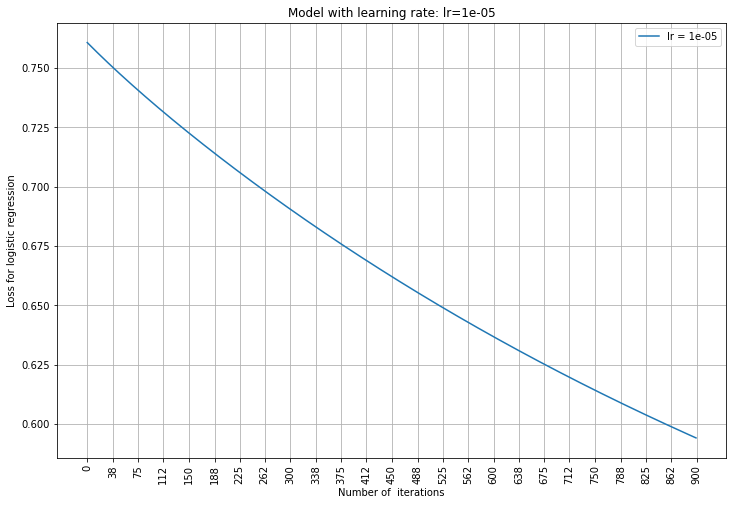

In [ ]:
def plot_fit(model, value, word, name):
    iter = [*range(model.max_iter)]
    tick = np.around(np.linspace(0, model.max_iter, 25), decimals=0)
    loss = model.loss_container
    plt.figure(figsize=(12, 8))
    plt.ylabel("Loss for logistic regression")
    plt.xlabel("Number of  iterations")
    plt.plot(iter, loss, label=f"{word} = {value}")
    plt.grid(True)
    plt.xticks(tick, rotation='vertical')
    plt.legend(loc='best')    
    plt.title(f'Model with {name}: {word}={value}')
    plt.show()

LEARNING_RATE = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]


for i, lr in enumerate(LEARNING_RATE):
    iter = 100 * (i + 2)
    model = CustomLogisticRegression(eta=lr, max_iter=iter)
    model.fit(X_train, y_train)
    plot_fit(model, lr, 'lr', 'learning rate')




Выше выведены графики loss для разных learning rate. Видно, что с уменьшением значения learning rate, увеличивается точность схождения алгоритма, но при это увеличивается время приближения к оптимуму. Видно, что при learning rate = 0.01 получаем оптимум за 20 итераций и loss = 0.5, а при learning rate = 0.00005 loss ниже 0.45 и мы еще даже не вышли на оптимум, хотя прошло уже 800 итераций, а в самом последнем случае, мы за 900 итераций только приближаемся к loss = 0.6

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [ ]:
REG_STR = np.around(np.linspace(0.1, 1, 10), decimals=1)

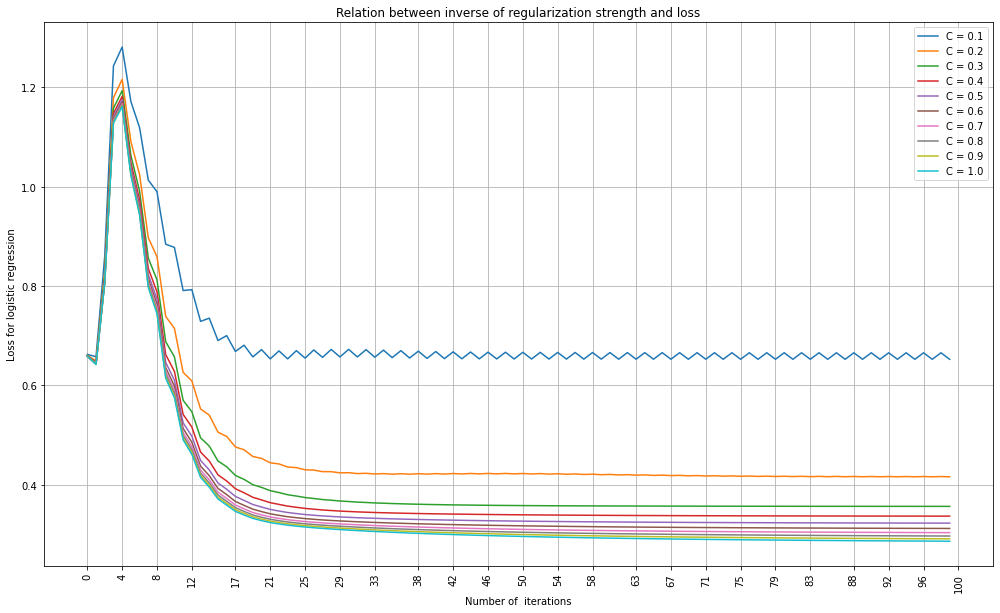

In [ ]:
hyper = []

for reg in REG_STR:
    model = CustomLogisticRegression(eta=0.005, max_iter=100, C=reg)
    model.fit(X_train, y_train)
    hyper.append(model.loss_container)


def multy_plot_fit(iter, losses, hyper_list, param_name, title):
    tick = np.around(np.linspace(0, iter, 25), decimals=0)
    iter = [*range(iter)]
    color_list = ['indianred', 'coral', 'darkorange', 'olivedrab', 'forestgreen', 'dodgerblue', 'slateblue', 'purple']
    plt.figure(figsize=(17, 10))
    counter = 0
    for loss in losses:
        plt.plot(iter, loss, label=f"{param_name} = {hyper_list[counter]}")
        counter += 1
    plt.title(title)
    ylabel = "Loss for logistic regression"
    xlabel = "Number of  iterations"
    plt.xticks(tick, rotation='vertical')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper right')
  
    plt.show()

multy_plot_fit(100, hyper, REG_STR, 'C', "Relation between inverse of regularization strength and loss")

Выведены графики зависимости регуляризации от параметра С (обратный коэффициент регуляризации) меняющемуся от 0.1 до 1.0 с шагом 0.1. По приведенным графикам видно обратную зависимость loss от параметра С, так как С стоит в знаменателе. С уменьшением С возрастает влияние регуляризации.

**(0.25 points)** Compare zero initialization and random initialization. 

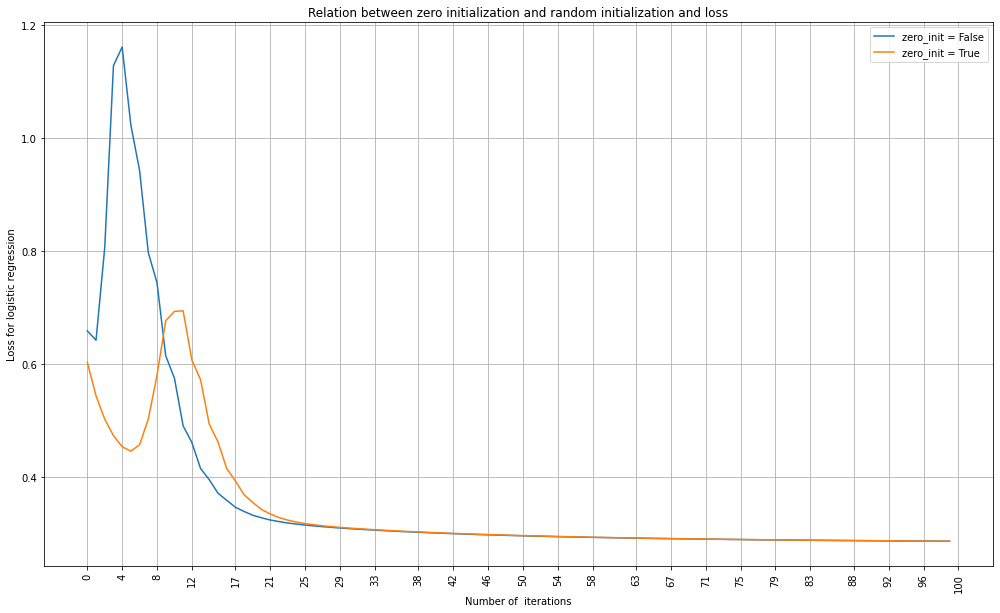

In [ ]:
hyper = []
INITIATION = [False, True]

for elem in INITIATION:
    model = CustomLogisticRegression(eta=0.005, max_iter=100, zero_init=elem)
    model.fit(X_train, y_train)
    hyper.append(model.loss_container)

multy_plot_fit(100, hyper, INITIATION, 'zero_init', "Relation between zero initialization and random initialization and loss")

Приведенны 2 графика зависимости loss функции от инициализации весов нулями или случайными значениями. Видно, что при случайных значениях весов оптимизатор быстрее находит нужное направление градиентного спуска, но на первоначальных этапах за счет наличия весов успевает несколько раз шагнуть в сторону увеличения лосса. 

При нулевых весах оптимизатор уменьшает ошибку, и видимо попадает в локальный оптимум из которого выбирается путем изменения весов. Уже примерно к 30 итерации уже нет различий между видами начальной инициализации весов.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(X points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [5]:
def distance(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        pair_dist = []
        for x in X:
            
            temp = []
            for y in Y:
                temp.append(distance(x, y))
            pair_dist.append(temp)
        return np.asarray(pair_dist)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        zero_weights = np.zeros_like(weights)
        for i in np.argsort(-weights)[0:self.n_neighbors]:
            zero_weights[i] = weights[i]

        temporary = [(y[i], zero_weights[i]) for i,v in enumerate(y)]
        keys = self.classes_
        values = [0] * len(y)
        dictionary = dict(zip(keys, values))
        for i,v in enumerate(temporary):
            dictionary[v[0]] += v[1]

        return np.asarray(list(dictionary.values()))
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)   
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            final_proba = []

            if self.weights == 'distance':
                weights = 1 / (P + self.eps)
                weights_of_points = np.zeros_like(P)

                for i in range(weights.shape[0]):
                    for j in np.argsort(-weights[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = weights[i][j]

                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) for i in range(weights_of_points.shape[0])])
                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

            if self.weights == 'uniform':
                weights_of_points = np.zeros_like(P)
                for i in range(P.shape[0]):
                    for j in np.argsort(P[i])[0:self.n_neighbors]:
                        weights_of_points[i][j] = 1
                class_proba = np.asarray([self.get_class_weights(self.y, weights_of_points[i]) for i in range(weights_of_points.shape[0])])

                for i in range(class_proba.shape[0]):
                    final_proba.append([class_proba[i][j] / np.sum(class_proba[i]) for j in range(class_proba.shape[1])])
                return np.asarray(final_proba)

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        return np.argmax(self.predict_proba(X), axis=1)

In [ ]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

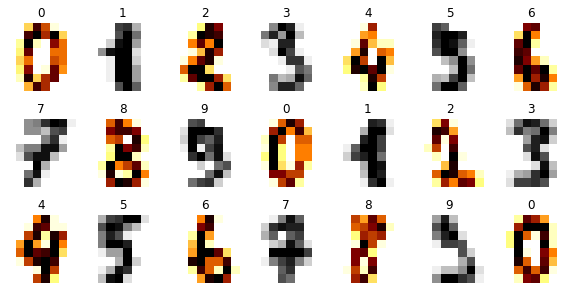

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


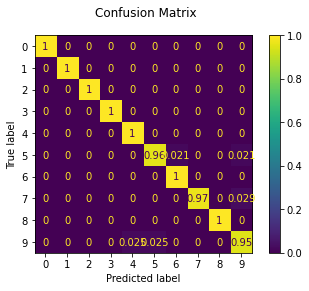

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
print(train_acc, test_acc)

1.0 0.9861111111111112


In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(X points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Как мы видим классификатор сомневается на таких парах как 5-9, 4-9, 7-9, 5-6. Если посмотреть в датасете на эти числа и сравнить их визуально, то можно заметить достаточно высокую схожесть цифры 4 и 9, ну и другие по этому же критерию. Думаю у классификатора эти цифры лежат на сопоставимом расстоянии, вот и проявляется вероятность нескольких классов.


**(X points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
from sklearn import neighbors
results = {}
neighbors = [*range(1,100)]
for neighbor in neighbors:
    model = CustomKNeighborsClassifier(n_neighbors=neighbor, weights='distance')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    results[f"neighbors = {neighbor}"] = test_acc

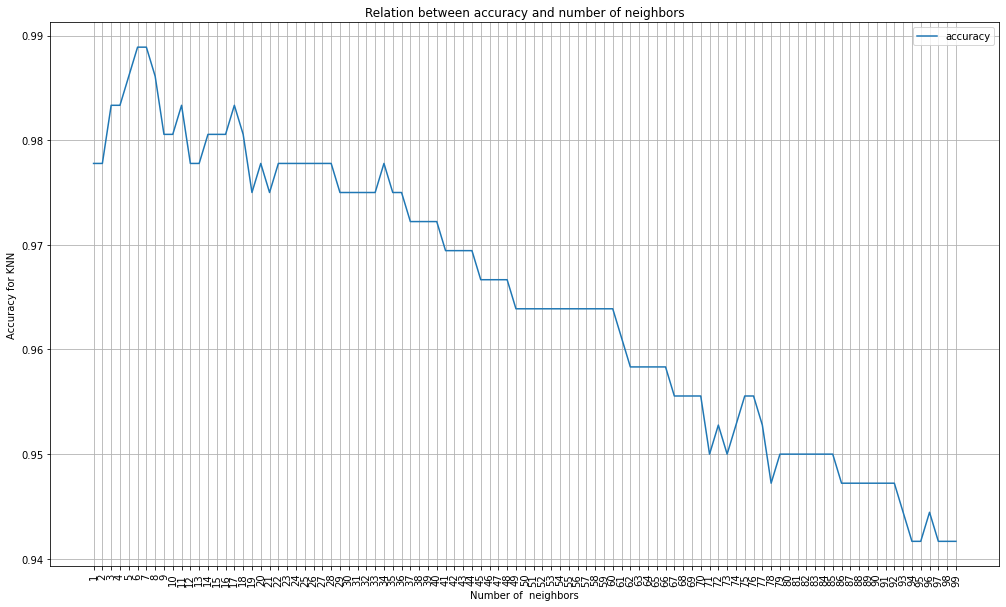

In [ ]:
plt.figure(figsize=(17, 10))

plt.plot(neighbors, list(results.values()), label="accuracy")
tick = [range(1, neighbors[-1], 5)]
plt.title('Relation between accuracy and number of neighbors')
ylabel = "Accuracy for KNN"
xlabel = "Number of  neighbors"
plt.xticks(neighbors, rotation='vertical')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


С увеличением количества соседей, точность сначала недолго растет, а потом начинает падать, видимо потому что количество классов объектов которые попадают в К соседей начинает выравниваться по колличеству и классификатор перестает уверенно выделять главный класс среди соседей. 

**(X points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
results_uni = []
for neighbor in neighbors:
    model_uni = CustomKNeighborsClassifier(n_neighbors=neighbor, weights='uniform')
    model_uni.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model_uni.predict(X_test), y_true=y_test)
    results_uni.append(test_acc)

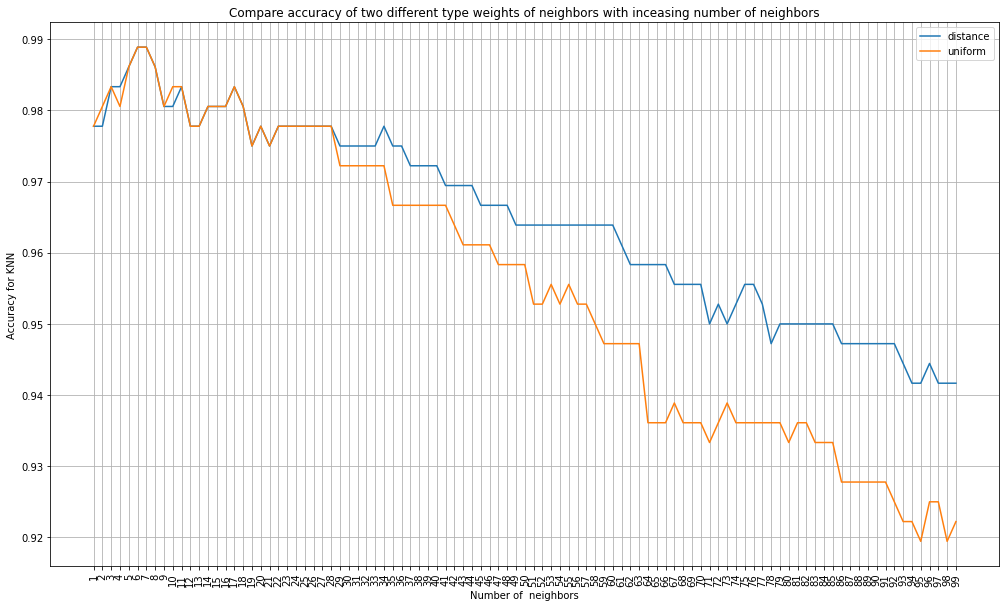

In [ ]:
plt.figure(figsize=(17, 10))

plt.plot(neighbors, list(results.values()), label="distance")
plt.plot(neighbors, results_uni, label="uniform")
tick = [range(1, neighbors[-1], 5)]
plt.title('Compare accuracy of two different type weights of neighbors with inceasing number of neighbors')
ylabel = "Accuracy for KNN"
xlabel = "Number of  neighbors"
plt.xticks(neighbors, rotation='vertical')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

Графики зависимости точности от типа KNN uniform или disatance. Видим, что примерно до K = 28 типы KNN не показывают особых различий в точности, но вот после видно, что точность uniform падает гораздо быстерее чем у distance. Видимо сказывается то, что у uniform все объекты которые попали в К соседей делают одинаковый вклад в определение доминирующего класса, независимо от их расстояния до классифицируемого объекта. Тогда как distance имеет вес, обратнопропорциональный расстоянию до определяемого объекта. 

Преимущества distance перед uniform является то, что эта метрика более устойчива к выбросам за счет наличия веса.

In [14]:
model_uni = CustomKNeighborsClassifier(n_neighbors=65, weights='uniform')
model_uni.fit(X_train, y_train)
model_dis = CustomKNeighborsClassifier(n_neighbors=65, weights='distance')
model_dis.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


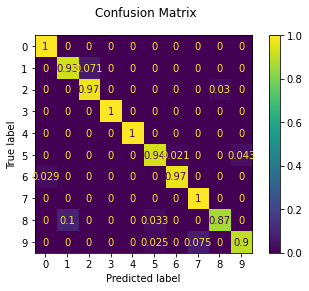

1.0 0.9583333333333334


In [15]:
train_acc, test_acc = fit_evaluate(model_dis, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


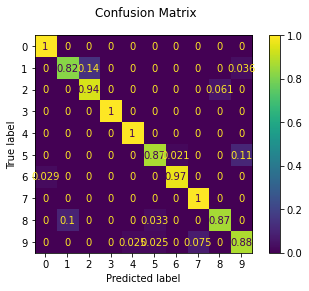

0.9380654140570633 0.9361111111111111


In [13]:
train_acc, test_acc = fit_evaluate(model_uni, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

Так же видно как модель с весами uniform больше сомневается в классификации нежели distance, у которой чуть более высокие вероятности на диагонали confusion matrix.

**(X points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Манхеттеновсое расстояние, расстояние Чебышева. Графики для KNN с этими функциями нарисованы ниже. По графику видно, что использование растояния Чебышева дает более высокую точность при весах до 3 и от 8 до 20 и от 36 до 46 соседей. 

**(X points)** Suggest different task and distance function that you think would be suitable for it.

In [ ]:
# Манхеттеновское расстояние
def distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

results_manh = []
for neighbor in neighbors:
    model = CustomKNeighborsClassifier(n_neighbors=neighbor, weights='distance')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    results_manh.append(test_acc)

In [ ]:
# расстояние Чебышева
def distance(x1, x2):
    return np.max (np.abs (x1 - x2)) 

results_cheb = []
for neighbor in neighbors:
    model = CustomKNeighborsClassifier(n_neighbors=neighbor, weights='distance')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    results_cheb.append(test_acc)

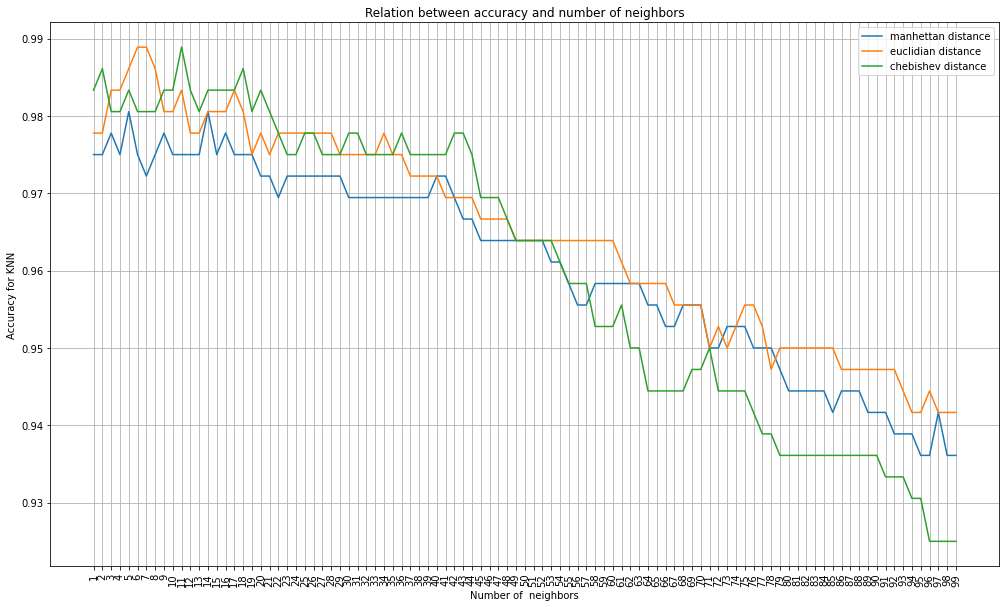

In [ ]:
plt.figure(figsize=(17, 10))

plt.plot(neighbors, results_manh, label="manhettan distance")
plt.plot(neighbors, list(results.values()), label="euclidian distance")
plt.plot(neighbors, results_cheb, label="chebishev distance")
tick = [range(1, neighbors[-1], 5)]
plt.title('Relation between accuracy and number of neighbors')
ylabel = "Accuracy for KNN"
xlabel = "Number of  neighbors"
plt.xticks(neighbors, rotation='vertical')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

Все мысли какие были связанны с расстояними я изложил выше и привел графики в пример. Какие расстояния для каких целей применяются я, честно говоря не знаю. Могу сказать лишь, что эвклидово расстояние -  просто прямая между двумя точками, манхеттеновское - это как будто мы идем по тетради в клеточку, только по линиям (ломанная траектория, его еще называют расстоянием городских кварталов), а Чебышева, это если мы идем из точки в точку по шахматной доске, как король например. Его еще называют расстояние шахматной доски (движения прямо и по диагонали равнозначны). Но сказать для какиех задач, какое расстояние применять я не могу.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
PATH = "./data/"
PATH = "/content/gdrive/MyDrive/RS_school_course/5_classification_linear_knn/titanic/train.csv.zip"

# original_data = pd.read_csv(PATH)

In [7]:
data = pd.read_csv(PATH).set_index('PassengerId')

In [8]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

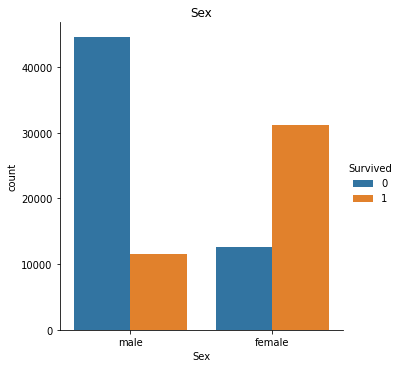

Sex     Survived
female  0           12660
        1           31226
male    0           44566
        1           11548
Name: Sex, dtype: int64
Количество выживших жещин 71.2% от всех женщин, мужчин 20.6% от всех мужчин
Количество выживших жещин 31.2%, мужчин 11.5% от всех людей
Количество погибших жещин 28.8% от всех женщин, мужчин 79.4% от всех мужчин
Количество погибших жещин 12.7%, мужчин 44.6% от всех людей


In [9]:
g = sns.catplot(x="Sex", kind='count', hue='Survived', data=data).set(title='Sex')
plt.show()

d = data.groupby(['Sex', 'Survived']).Sex.count()
female = d[0] + d[1]
male = d[2] + d[3]
print(d)
print(f"Количество выживших жещин {round(d[1]/female * 100, 1)}% от всех женщин, мужчин {round(d[3]/male * 100, 1)}% от всех мужчин")
print(f"Количество выживших жещин {round(d[1]/(female+male)* 100, 1)}%, мужчин {round(d[3]/(female+male) * 100, 1)}% от всех людей")
print(f"Количество погибших жещин {round(d[0]/female * 100, 1)}% от всех женщин, мужчин {round(d[2]/male * 100, 1)}% от всех мужчин")
print(f"Количество погибших жещин {round(d[0]/(female+male) * 100, 1)}%, мужчин {round(d[2]/(female+male) * 100, 1)}% от всех людей")

Есть связь между Sex и Survived. По графику видно, что большая часть тех кто погиб это мужчины, а выживших - женщины. Выжило 71% жищин и 20% мижчин. Женщин погибла только треть, а мужчин почти четыре пятых части.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

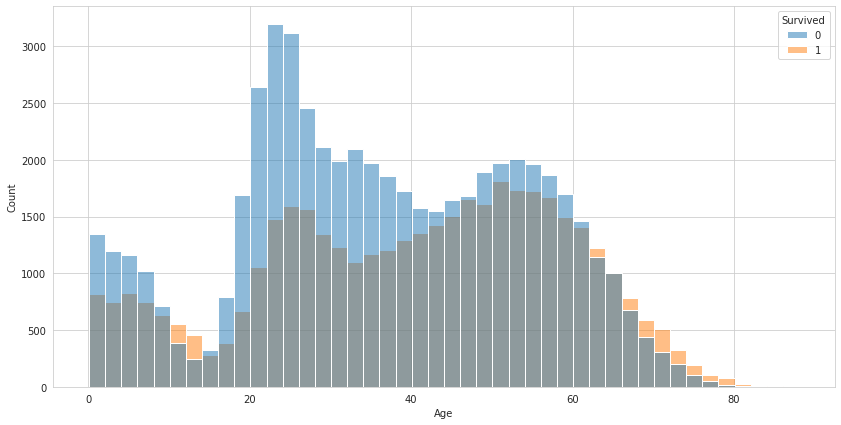

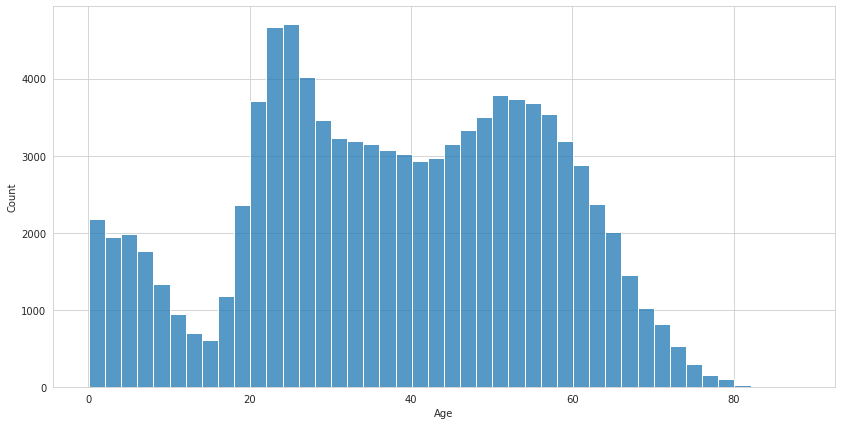

Средний возраст выживших 40.6, медиана 43.0. Средний возраст погибших 36.7, медиана 36.0.


In [10]:
plt.figure(figsize=(14,7))
sns.set_style("whitegrid")
sns.histplot(data=data, x='Age', hue="Survived", edgecolor="white", linewidth=1, binwidth=2, multiple="layer")
plt.show()

plt.figure(figsize=(14,7))
sns.set_style("whitegrid")
sns.histplot(data=data, x='Age', edgecolor="white", linewidth=1, binwidth=2, multiple="layer")
plt.show()

data.loc[data.Survived == 1]['Age'].mean()
mean_1 = data.query(f'Survived == 1').Age.mean()
median_1 = data.query(f'Survived == 1').Age.median()
mean_0 = data.query(f'Survived == 0').Age.mean()
median_0 = data.query(f'Survived == 0').Age.median()

print(f"Средний возраст выживших {round(mean_1, 1)}, медиана {round(median_1, 1)}. Средний возраст погибших {round(mean_0, 1)}, медиана {round(median_0, 1)}.")

Из графика видно, что основная масса тех кто выжил находятся или в категории детского возраста, а также старше 60 лет. Основная масса погибших это люди от 16 до 60 лет.

Средний возраст и медиана выживших чуть больше, чем погибших, думаю это связано со статусом пассажиров, а также с тем, что в категории от 20-60 лет ехало самое большое количество пассажиров.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

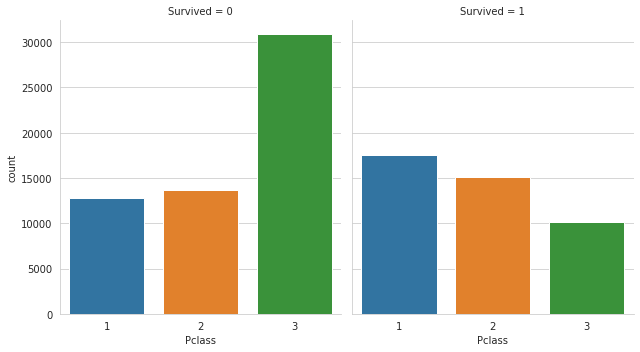

In [11]:
g = sns.catplot(x="Pclass", col="Survived",
                data=data, kind="count", height=5, aspect=.9)

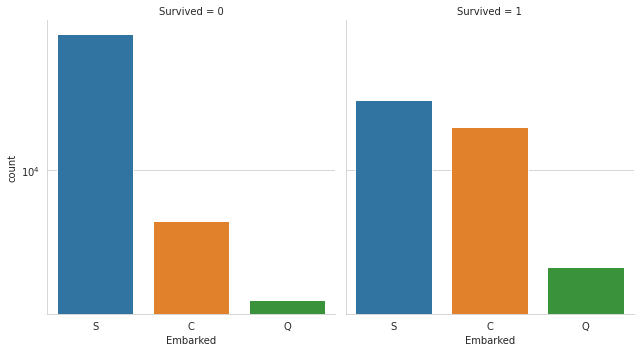

In [12]:
g = sns.catplot(x="Embarked", col="Survived", log=True,
                data=data, kind="count", height=5, aspect=.9)

In [13]:
port = data.Embarked.value_counts()
print(f"В перечисленных ниже портах на борт погрузилось : ")
for i in range(len(port)):
    print(f"       в порту {port.index[i]}  : {port[i]} пассажиров ")

pclass = data.Pclass.value_counts()
print(f"Количество пассажиров по классам : ")
for i in range(len(pclass)):
    print(f"       в классе {pclass.index[i]}  : {pclass[pclass.index[i]]} пассажиров ")

В перечисленных ниже портах на борт погрузилось : 
       в порту S  : 72139 пассажиров 
       в порту C  : 22187 пассажиров 
       в порту Q  : 5424 пассажиров 
Количество пассажиров по классам : 
       в классе 3  : 41006 пассажиров 
       в классе 1  : 30315 пассажиров 
       в классе 2  : 28679 пассажиров 


Видно, что у большинства погибших были билеты 3 класса, и сели они в порту Southampton, хотя судя по количеству там, село большинство пассажиров, так же как пассажиров 3 класса больше всего по колличеству среди всех классов.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [14]:
mis_data = data.isnull().sum()
print(mis_data)
print('\nКоличество пропущенных значений по категориям в %')
for i, v in enumerate(mis_data.values):
    if v:
        print(f"{mis_data.index[i]} :   {(v / data.shape[0]) * 100} %")

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

Количество пропущенных значений по категориям в %
Age :   3.292 %
Ticket :   4.623 %
Fare :   0.134 %
Cabin :   67.866 %
Embarked :   0.25 %


In [15]:
# Скопируем датафрейм

df = data.copy()
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [16]:
# Заменим пропущеные значения в Fare средним по классу исключая выбросы
def irq(number, pclass=0):
    if pclass == 0:
        quantile = number.Fare.describe()
    else:
        quantile = number.query(f"Pclass == {pclass}").Fare.describe()
    q25 = quantile['25%']
    q50 = quantile['50%']
    q75 = quantile['75%']
    IRQ = q75 - q25
    limit = q75 + 1.5*IRQ
    return (q25, q50, q75, limit)


# среднее по классу
mean_1 = df.query(f'Pclass == 1 and Fare < {irq(df, 1)[3]}').Fare.mean()
mean_2 = df.query(f'Pclass == 2 and Fare < {irq(df, 2)[3]}').Fare.mean()
mean_3 = df.query(f'Pclass == 3 and Fare < {irq(df, 3)[3]}').Fare.mean()

# Заменяем средним по классу
df.loc[(df["Fare"].isna()) & (df['Pclass'] == 1), 'Fare'] = mean_1
df.loc[(df["Fare"].isna()) & (df['Pclass'] == 2), 'Fare'] = mean_2
df.loc[(df["Fare"].isna()) & (df['Pclass'] == 3), 'Fare'] = mean_3

In [17]:
# Средний возрас по полу
df['Sex'] = df['Sex'].astype('category')
mean_age_f = df.loc[df.Sex == 'female'].Age.mean()
mean_age_m = df.loc[df.Sex == 'male'].Age.mean()

# Заменяем средний пропущенный возраст средним по полу
df.loc[(df["Age"].isna()) & (df['Sex'] == 'female'), 'Age'] = mean_age_f
df.loc[(df["Age"].isna()) & (df['Sex'] == 'male'), 'Age'] = mean_age_m

In [18]:
# Заполняем пропуски в категории Embarked самым частым значением
emb_fill = df['Embarked'].value_counts().index[0]
df['Embarked'] = df['Embarked'].fillna(emb_fill)

In [19]:
mis_data = df.isnull().sum()
print(mis_data)

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket       4623
Fare            0
Cabin       67866
Embarked        0
dtype: int64


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Можно просто удалить строки с пропущенными значениями, но это потеря данных, которых может быть и так не много. Можно заменить или медианой или средним. Это почти не влияет на статистические характеристики данных, но медиана например более устойчива к выбросам, если они присутствуют. Можно заменять модой.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [21]:
df_2 = df.copy()
df_2['Cabin'] = df_2['Cabin'].fillna('empty')
# fare_med = df_2.Fare.mean()
df_2['Deck'] = df_2['Cabin'].map(lambda x: x[0] if x[0].isupper() else 'empty')

df_2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,37.030884,2,0,209245,27.14,C12239,S,C
1,0,3,"Bryan, Drew",male,37.030884,0,0,27323,13.35,empty,S,empty
2,0,3,"Owens, Kenneth",male,0.330000,1,2,CA 457703,71.29,empty,S,empty
3,0,3,"Kramer, James",male,19.000000,0,0,A. 10866,13.04,empty,S,empty
4,1,3,"Bond, Michael",male,25.000000,0,0,427635,7.76,empty,S,empty


In [25]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()
df_2['Sex'] = le.fit_transform(df_2["Sex"])
df_2['Deck'] = le.fit_transform(df_2["Deck"])
df_2['Embarked'] = le.fit_transform(df_2["Embarked"])


In [23]:
df_2.corr()['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.187479
Age         0.103516
Parch       0.023352
SibSp      -0.007587
Deck       -0.207727
Pclass     -0.289723
Embarked   -0.370688
Sex        -0.507260
Name: Survived, dtype: float64

In [28]:
df_2.drop(columns=['SibSp', 'Parch', 'Name', 'Ticket', 'Cabin'], inplace=True)
df_2.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck
PassengerId,,,,,,,
0,1,1,1,37.030884,27.14,2,2
1,0,3,1,37.030884,13.35,2,8
2,0,3,1,0.330000,71.29,2,8
3,0,3,1,19.000000,13.04,2,8
4,1,3,1,25.000000,7.76,2,8


In [29]:
# Делим данные

SEED = 42

X = df_2.drop('Survived', axis=1)
y = df_2['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=SEED)

In [30]:
mis_data = X_train.isnull().sum()
print(mis_data)

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Deck        0
dtype: int64


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def make_model(degree, col):
    preprocessor = ColumnTransformer([('new', PolynomialFeatures(degree, include_bias=(degree == 0)), col)], remainder='passthrough')    
    return Pipeline([
                     ('preprocessor', preprocessor), 
                     ('sca', StandardScaler()),
    ])
degree = 2
col = ['Fare', 'Age']
preprocessor = make_model(degree, col)

In [37]:
from pandas.core.common import random_state
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randInt


clf = LogisticRegression(random_state=SEED, class_weight = 'balanced')

parameters = {'C'             : sp_randFloat(loc=1, scale=5),
              'solver'        : ['newton-cg', 'sag', 'lbfgs', 'liblinear'],
              'penalty': ['l2'],
              }
search = RandomizedSearchCV(clf, parameters, n_iter=200, cv=7, verbose=0, n_jobs=-1, scoring='accuracy', random_state=SEED)
                       
search.fit(pd.DataFrame(preprocessor.fit_transform(X_train)), y_train)



In [38]:
from sklearn import metrics

print(search.best_params_)
print(metrics.accuracy_score(y_pred=search.predict(preprocessor.fit_transform(X_train)), y_true=y_train))
print(metrics.accuracy_score(y_pred=search.predict(preprocessor.fit_transform(X_test)), y_true=y_test))

{'C': 1.2904180608409974, 'penalty': 'l2', 'solver': 'liblinear'}
0.76552
0.76288


In [ ]:
# выше результаты для Логистической регрессии
# **************************************************************************************************************

In [41]:
from sklearn.model_selection import GridSearchCV


model = KNeighborsClassifier()

parameters = {
              'n_neighbors'   : [2,3,4,5,6,7,8,9,10,11,12],
              'weights'          : ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'chebyshev'],
              }
gridKnn = GridSearchCV(model, parameters, cv=5, verbose=0, n_jobs=-1, scoring='accuracy')
                       
gridKnn.fit(pd.DataFrame(preprocessor.fit_transform(X_train)), y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [44]:
print(gridKnn.best_params_)

print(metrics.accuracy_score(y_pred=gridKnn.predict(preprocessor.fit_transform(X_train)), y_true=y_train))
print(metrics.accuracy_score(y_pred=gridKnn.predict(preprocessor.fit_transform(X_test)), y_true=y_test))

{'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'uniform'}
0.79736
0.76376


In [46]:
# Считываем тестовые данные для Каггла

PATH = "/content/gdrive/MyDrive/RS_school_course/5_classification_linear_knn/titanic/test.csv.zip"
data_t = pd.read_csv(PATH).set_index('PassengerId')

In [49]:
# среднее по классу
mean_1 = data_t.query(f'Pclass == 1 and Fare < {irq(data_t, 1)[3]}').Fare.mean()
mean_2 = data_t.query(f'Pclass == 2 and Fare < {irq(data_t, 2)[3]}').Fare.mean()
mean_3 = data_t.query(f'Pclass == 3 and Fare < {irq(data_t, 3)[3]}').Fare.mean()

# Заменяем средним по классу
data_t.loc[(data_t["Fare"].isna()) & (data_t['Pclass'] == 1), 'Fare'] = mean_1
data_t.loc[(data_t["Fare"].isna()) & (data_t['Pclass'] == 2), 'Fare'] = mean_2
data_t.loc[(data_t["Fare"].isna()) & (data_t['Pclass'] == 3), 'Fare'] = mean_3

# Средний возрас по полу
df['Sex'] = data_t['Sex'].astype('category')
mean_age_f = data_t.loc[data_t.Sex == 'female'].Age.mean()
mean_age_m = data_t.loc[data_t.Sex == 'male'].Age.mean()

# Заменяем средний пропущенный возраст средним по полу
data_t.loc[(data_t["Age"].isna()) & (data_t['Sex'] == 'female'), 'Age'] = mean_age_f
data_t.loc[(data_t["Age"].isna()) & (data_t['Sex'] == 'male'), 'Age'] = mean_age_m


# Заполняем пропуски в категории Embarked самым частым значением
emb_fill = data_t['Embarked'].value_counts().index[0]
data_t['Embarked'] = data_t['Embarked'].fillna(emb_fill)


data_t['Cabin'] = data_t['Cabin'].fillna('empty')
data_t['Deck'] = data_t['Cabin'].map(lambda x: x[0] if x[0].isupper() else 'empty')

# Кодируем признаки
le = preprocessing.LabelEncoder()
data_t['Sex'] = le.fit_transform(data_t["Sex"])
data_t['Deck'] = le.fit_transform(data_t["Deck"])
data_t['Embarked'] = le.fit_transform(data_t["Embarked"])
data_t.drop(columns=['SibSp', 'Parch', 'Name', 'Ticket', 'Cabin'], inplace=True)
data_t.head()

,Pclass,Sex,Age,Fare,Embarked,Deck
PassengerId,,,,,,
100000,3,1,19.0,63.01,2,8
100001,3,0,53.0,5.81,2,8
100002,1,0,19.0,38.91,0,1
100003,2,1,25.0,12.93,2,8
100004,1,0,17.0,26.89,0,1


In [53]:
data_t.head()

,Pclass,Sex,Age,Fare,Embarked,Deck
PassengerId,,,,,,
100000,3,1,19.0,63.01,2,8
100001,3,0,53.0,5.81,2,8
100002,1,0,19.0,38.91,0,1
100003,2,1,25.0,12.93,2,8
100004,1,0,17.0,26.89,0,1


In [55]:
answer = pd.DataFrame(gridKnn.predict(preprocessor.fit_transform(data_t)), columns=['Survived'])
# gridKnn
answer.index = np.arange(100000, len(answer)+100000)
answer.index.name = 'PassengerId' 


answer.to_csv('/content/gdrive/MyDrive/RS_school_course/5_classification_linear_knn/titanic/out.csv') 

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code
# Настраивал гиперпараметры я выше по коду функцией RandomizedSearchCV для логической регрессии, а для KNN функцией GridSearchCV.
# Делал новые признаки я тоже прямо в коде. Сделал признак Deck взял первую букву с Cabin, если есть empty, если нету. Также
# использовал всеми любимые PolynomialFeature на Age и Fare второй степени. Остальные признаки закодировал LabelEncoding.
# Дропнул все кроме Pclass, Sex, Age, Fare, Embarked, Deck. Эти признаки выбрал на основе метрицы корреляции (выкинул признаки с самой
# слабой корреляцие с Survived). 
# Посчитал 2 модели : LogisticRegression, параметры {'C': 1.2904180608409974, 'penalty': 'l2', 'solver': 'liblinear'}
#                     KNeighborsClassifier, параметры {'metric': 'chebyshev', 'n_neighbors': 11, 'weights': 'uniform'}

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.0, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 3.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

полученный score на Kaggle
 

*   для модели Logistic Regression : Score: 0.79345
*   для модели KNN : Score: 0.77399


Выводы написаны под пунктами. Работа как вы сдаете велась ударными  темпами, поэтому частично хромает текстовая часть, которая писалась в последний момент.



